In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.funcs.routines import *
import seaborn as sns

import h5py

In [85]:
base_string = f'bsub -gpu "num=1" -q gpu_any -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/predict.py'  

exps = ['msp300', 'N2_352', 'rab11', 'scrib', 'sgg', 'Dlg1']
ver = 'f1'
name = 'f1_none'

with open('run_slurm.sh', 'w') as f:
    for exp in exps:  
        cfg = OmegaConf.load(f'../config/experiment/{exp}_{ver}.yaml')
        
        model_path = cfg.output.save_dir + '_none/model.pkl'
        image_path =  str(Path(cfg.data_path.image_path).parent) + f'/{exp}*.tif'
        out_file = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/{exp}_{ver}.csv'
        
        exec_str = base_string + f' +out_file={out_file}  image_path={image_path} model_path={model_path}' + '\n'
        print(exec_str)
        f.write(exec_str)

bsub -gpu "num=1" -q gpu_any -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/predict.py +out_file=/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/msp300_f1.csv  image_path=/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300*.tif model_path=/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/msp300_smFISH/nb_run/msp300_f1_none/model.pkl

bsub -gpu "num=1" -q gpu_any -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/predict.py +out_file=/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/N2_352_f1.csv  image_path=/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deeps

In [198]:
def plot_3d_projections(volume, psf_vol, proj_func=np.max, size=6, vmax=None, display=True):

    if torch.is_tensor(volume):
        plot_vol = volume.detach().cpu().numpy()
    else:
        plot_vol = volume

    for _ in range(plot_vol.ndim - 3):
        plot_vol = plot_vol.squeeze(0)

    z,y,x = plot_vol.shape

    size_y = size * ((y+z)/y)
    size_x = size * ((1.1*x+z)/x)

    fig, ((ax_yx, ax_yz, ax_c), (ax_zx, ax_t1, ax_t2)) = plt.subplots(2, 3, figsize=(size_x,size_y), sharex='col', sharey=False,
                                                 gridspec_kw={'height_ratios': [y, z], 'width_ratios':[x, z, x/20]})
    plt.subplots_adjust(hspace=0.0,wspace=0.05)

    # usually imshow starts at -0.5 so we have to manually change that
    im = ax_yx.imshow(proj_func(plot_vol, 0),vmax=vmax, extent=(0,x,y,0))
    ax_yz.imshow(proj_func(plot_vol, 2).T,vmax=vmax, extent=(0,z,y,0))
    ax_zx.imshow(proj_func(plot_vol, 1),vmax=vmax, extent=(0,x,z,0))
    
    ax_t1.imshow(proj_func(psf_vol, 1), extent=(0,z,z,0))

    ax_t1.axis('off')
    ax_t2.axis('off')
#     ax_yz.axis('off')

    cb = fig.colorbar(im, cax=ax_c)
    cb.remove()

    ax_yx.axis('off')
    ax_zx.axis('off')
    ax_yz.axis('off')

    plt.tight_layout()

    if not display: plt.close(fig)

    return fig, [ax_yx,ax_zx,ax_yz,ax_t1]

def scat_3d_projections(axes, dfs, px_size_zyx=[1.,1.,1], s_fac=1.):
    colors = ['red','black','orange']
    markers = ['o','+','x']
    if not isinstance(dfs, list):
        dfs = [dfs]
    for i,df in enumerate(dfs):
        df = nm_to_px(df, px_size_zyx)
        axes[0].scatter(df['x'],df['y'], color=colors[i], marker=markers[i], s=10*s_fac, label=f'DF {i}')
        axes[1].scatter(df['x'],df['z'], color=colors[i], marker=markers[i], s=10*s_fac)
        axes[2].scatter(df['z'],df['y'], color=colors[i], marker=markers[i], s=10*s_fac)
#     axes[0].legend()

In [199]:
25/35*100

71.42857142857143

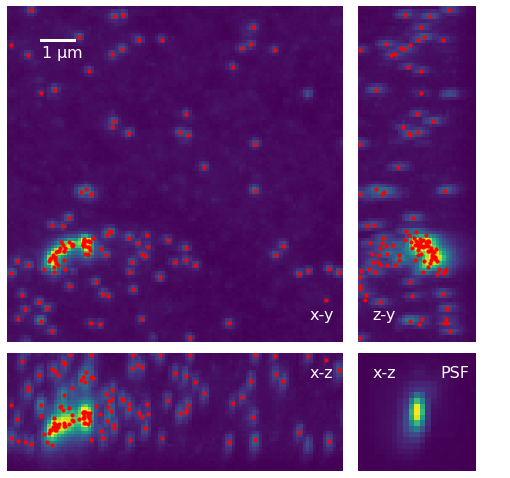

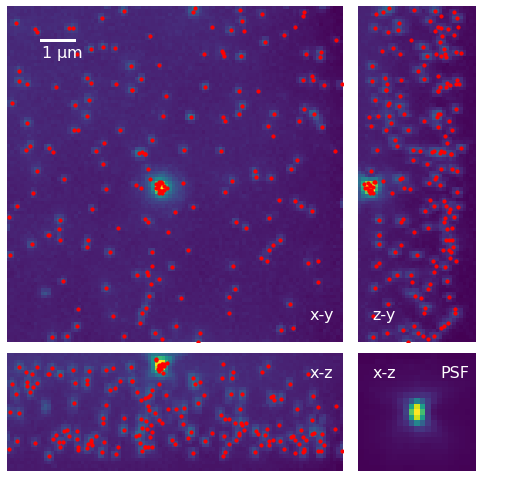

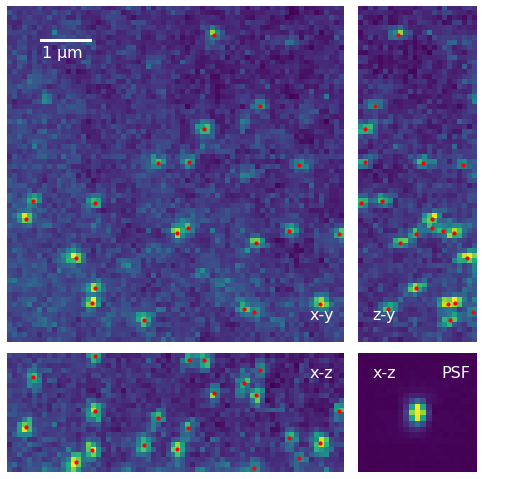

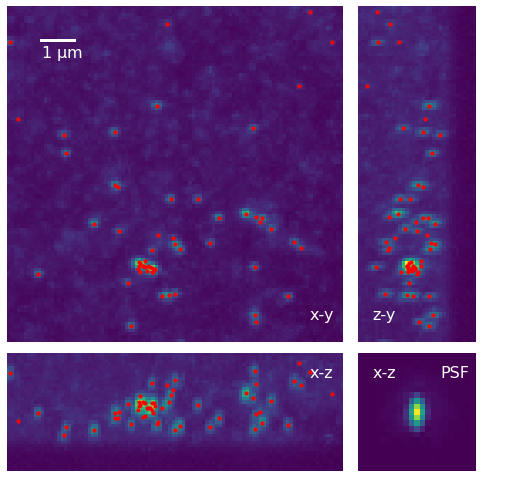

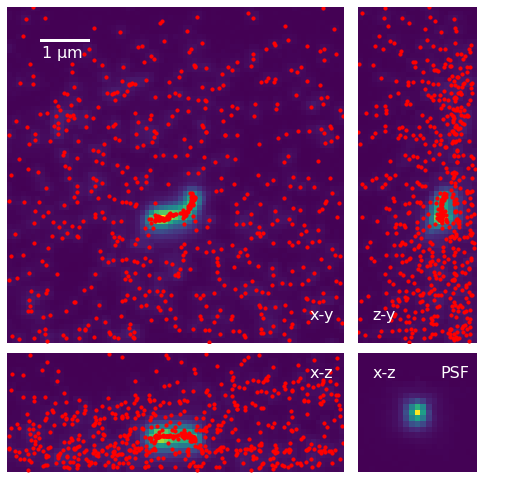

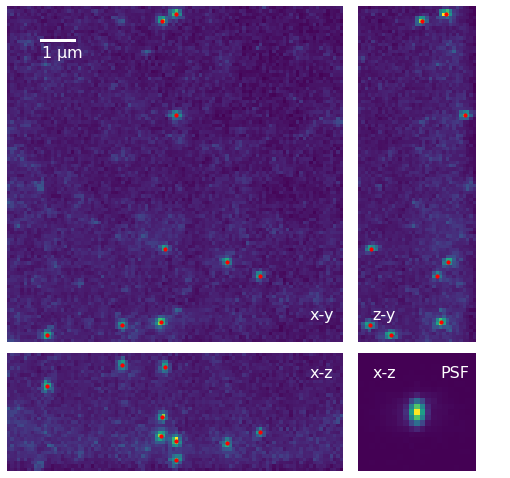

In [205]:
# Set ratio to 35:100
exp_sl = {}

exp_sl[exps[0]] = np.s_[:,:35,100:200,400:500]
exp_sl[exps[1]] = np.s_[:,16:,250:350,250:350]
exp_sl[exps[2]] = np.s_[:,:,132:200,432:500]
exp_sl[exps[3]] = np.s_[:,:,170:270,370:470]
exp_sl[exps[4]] = np.s_[:,:,50:121,400:471]
exp_sl[exps[5]] = np.s_[:,:35,100:200,400:500]

vexp = {}

for exp in exps:  
    
    cfg = OmegaConf.load(f'../config/experiment/{exp}_{ver}.yaml')
    cfg.output.save_dir = cfg.output.save_dir + '_none'
    image_paths =  sorted(glob.glob(str(Path(cfg.data_path.image_path).parent) + f'/{exp}*.tif'))
    img = load_tiff_image(cfg.data_path.image_path)
    
    ind = image_paths.index(str(Path(cfg.data_path.image_path)))
    
    sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
    if exp not in exp_sl: exp_sl[exp] = sl
    
    out_file = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/results/{exp}_{ver}.csv'
    
    dec_df = pd.read_csv(out_file)
    sub_df = dec_df[dec_df['frame_idx'] == ind]
    sub_df = crop_df(sub_df, exp_sl[exp], px_size_zyx=[100,100,100])
    
    _, noise, micro = load_psf_noise_micro(cfg)
    micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'))
    psf_vol = cpu(micro.psf.psf_volume[0])   
    
#     plot_3d_projections(psf_vol, psf_vol)
    if exp not in vexp:
        vexp[exp]=None
    
    fig, axes = plot_3d_projections(img[exp_sl[exp]], psf_vol, size=5, vmax=vexp[exp])
    _ = scat_3d_projections(axes, sub_df, px_size_zyx=[100,100,100])
    
    fac = img[exp_sl[exp]].shape[-1]/100

    axes[0].plot([10*fac,10*fac+10],[10*fac,10*fac],linewidth=3,color='white')
    axes[0].text(0.1,1-(0.15),'1 $\mathrm{\mu m}$',transform=axes[0].transAxes, fontsize=16,color='white')
    
    axes[0].text(0.9,0.07,'x-y',fontsize=16,color='white',transform=axes[0].transAxes)
    axes[1].text(0.9,0.8,'x-z',fontsize=16,color='white',transform=axes[1].transAxes)
    axes[2].text(0.12,0.07,'z-y',fontsize=16,color='white',transform=axes[2].transAxes)
    
    axes[3].text(0.12,0.8,'x-z',fontsize=16,color='white',transform=axes[3].transAxes)
    axes[3].text(0.7,0.8,'PSF',fontsize=16,color='white',transform=axes[3].transAxes)